# Discriminate between Basetracks from Electromagnetic Showers and from Background

The goal is to develop a prediction model to discriminate between electromagnetic shower generated basetracks and background basetracks. This is a binary classification task - 1 being electromagnetic shower generated basetracks, 0 being background basetracks.

The data is found here: https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_4/training.tgz - archive with brick volumes filled with labelled basetracks https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_4/test.h5.gz - volume with basetracks to discriminate

Each basetrack is described by 
+ Coordinates: (X, Y, Z)
+ Angles in the brick-frame: (TX, TY)

This was completed as part of the Addressing Large Hadron Collider Challenges with Machine Learning course as part of the Advanced Machine Learning specialisation on Coursera.

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'axis', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load Datasets

In [2]:
train = pd.read_hdf('data/open30.h5') #pick single brick
test = pd.read_hdf('data/test.h5')

In [3]:
test = test.reset_index(drop=True)

In [4]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [5]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


### How showers look like inside one data_ind

In [6]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [7]:
first = train.loc[train.data_ind == 21, :]

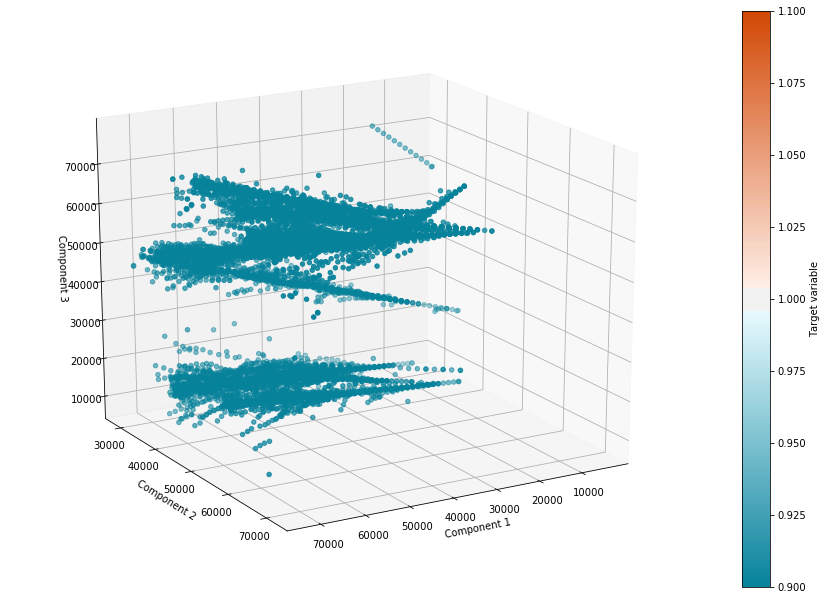

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

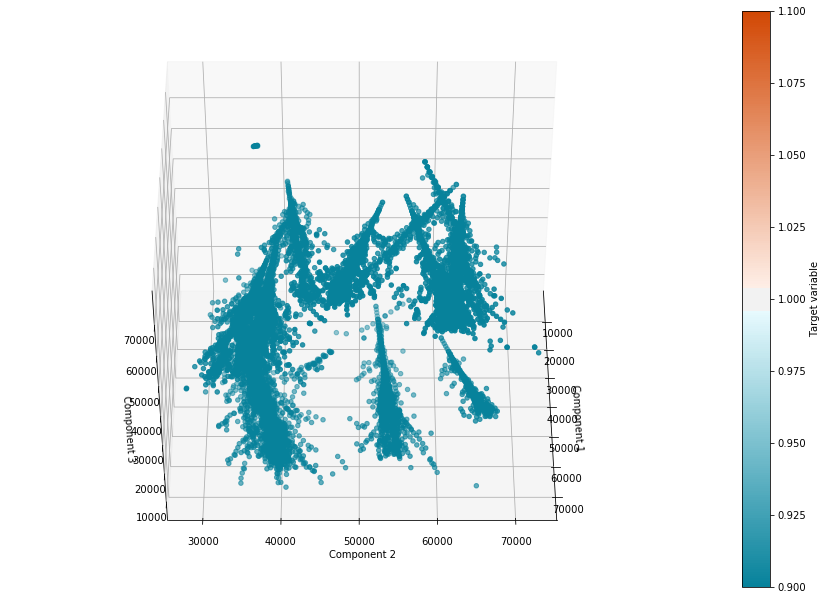

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

### Basetrack distribution along the axis

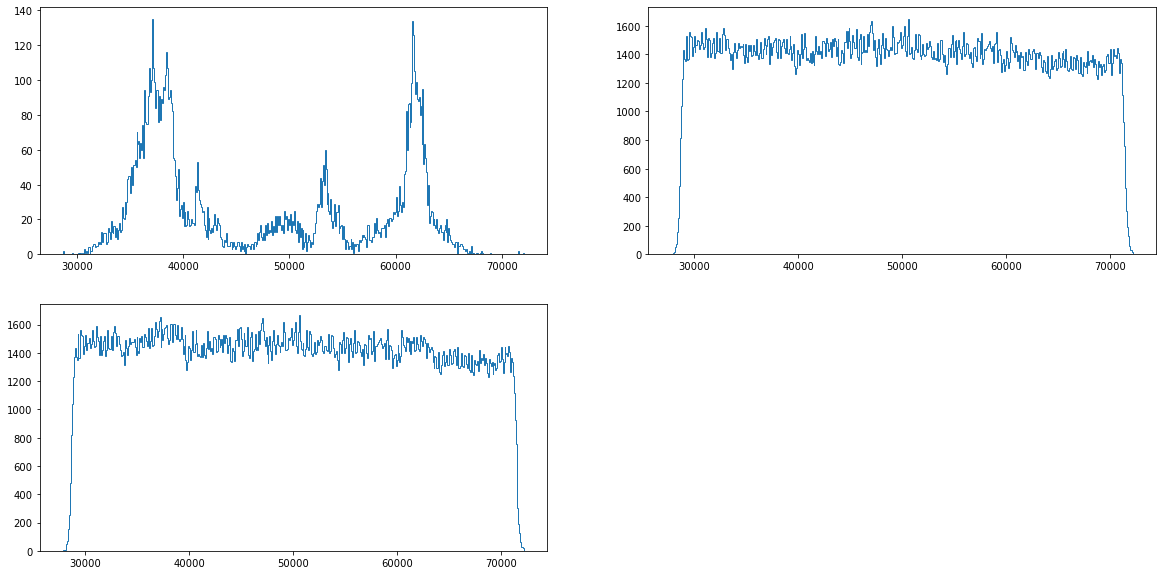

In [10]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

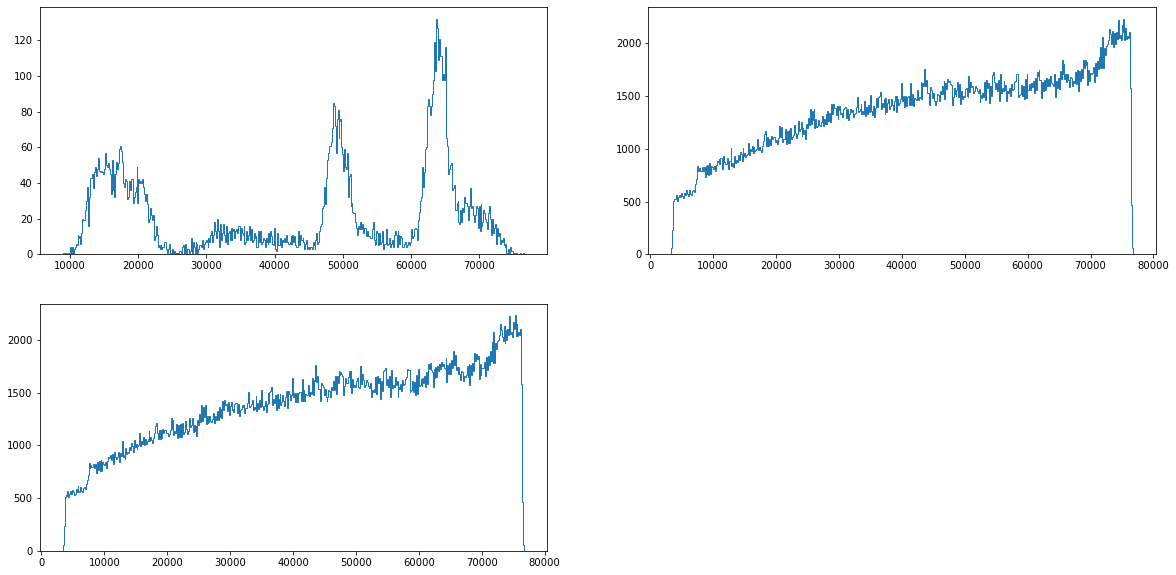

In [11]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

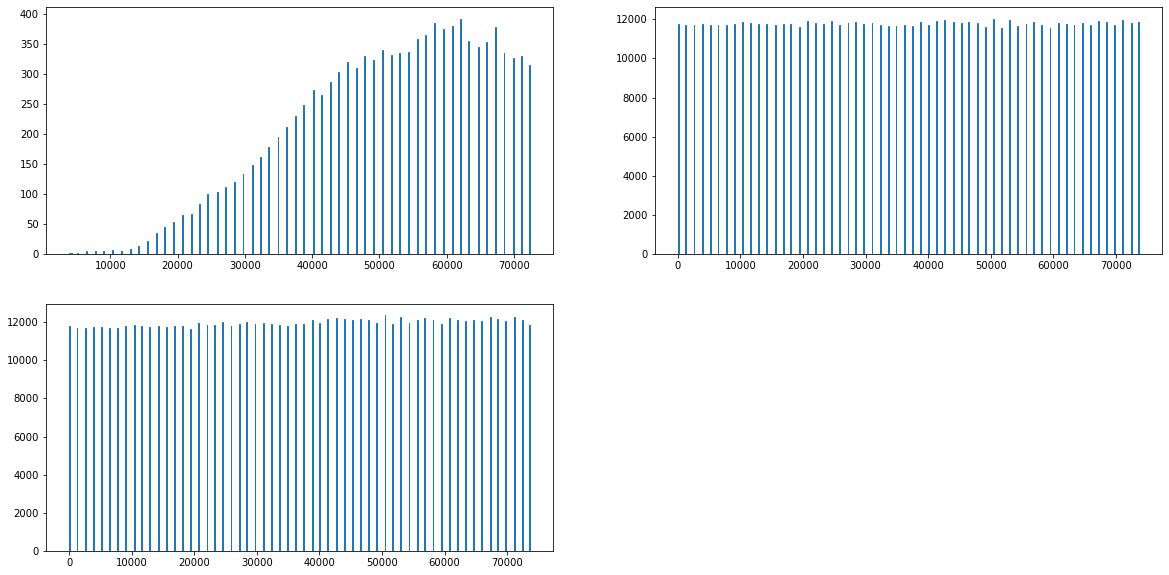

In [12]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

### Grouping close tracks from neighbour plates into pairs

In [13]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [14]:
train = []
for file in glob.glob('data/open*.h5')[:5]: # just 5 bricks
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


In [15]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind,TX_pair,TY_pair,X_pair,Y_pair,Z_pair,dTX,dTY,dX,dY,dZ
0,64.295792,120.471031,49545.425781,58027.636719,5172.000000,153997.0,1.0,271,85.199005,128.525360,49540.316406,58018.058594,5427.205078,-20.903214,-8.054329,5.109375,9.578125,-255.205078
1,85.199005,128.525360,49540.316406,58018.058594,5427.205078,189715.0,1.0,271,70.662689,122.620712,49611.359375,58146.925781,6465.000000,14.536316,5.904648,-71.042969,-128.867188,-1037.794922
2,85.199005,128.525360,49540.316406,58018.058594,5427.205078,189715.0,1.0,271,-117.009766,153.375397,49843.593750,58355.070312,6465.000000,202.208771,-24.850037,-303.277344,-337.011719,-1037.794922
3,85.199005,128.525360,49540.316406,58018.058594,5427.205078,189715.0,1.0,271,507.651611,42.330360,50004.304688,58237.914062,6465.000000,-422.452606,86.195000,-463.988281,-219.855469,-1037.794922
4,-1019.463440,-316.895508,60857.125000,34515.269531,6465.000000,183074.0,1.0,271,-967.443237,-311.478729,60936.945312,34540.082031,6702.123047,-52.020203,-5.416779,-79.820312,-24.812500,-237.123047


## Building a model

### XGBoost Classifier

In [16]:
from sklearn.model_selection import train_test_split
training_data, validation_data = train_test_split(train, random_state=11, train_size=0.90)
len(training_data), len(validation_data)

(4393031, 488115)

In [17]:
y_train = training_data.signal
X_train = training_data.drop(['event_id', 'signal', 'data_ind'], axis=1)

y_validation = validation_data.signal
X_validation = validation_data.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [18]:
# import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [19]:
param_grid = {
        'n_estimators':[50,100], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8, n_jobs=20), 
                   param_grid=param_grid, n_jobs=3,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)

In [22]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed: 13.1min remaining: 26.1min
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed: 13.1min remaining: 13.1min
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed: 37.8min remaining: 18.9min
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed: 38.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed: 38.1min finished


[06:14:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1,
                                         colsample_bytree=0.8, gamma=0,
                                         learning_rate=0.05, max_delta_step=0,
                                         max_depth=3, min_child_weight=1,
                                         missing=None, n_estimators=100,
                                         n_jobs=20, nthread=None,
                                         objective='binary:logistic',
                                         random_state=0, reg_alpha=0,
                                         reg_lambda=1, scale_pos_weight=1,
                                         seed=None, silent=None, subsample=0.8,
                                      

In [23]:
xgb_class = clf.best_estimator_

In [24]:
val_probas = xgb_class.predict(X_validation)

In [25]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_validation, val_probas))

0.9449097994334592


### DNN

In [26]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))
X_val_norm = transformer.transform(X_validation.fillna(0))

In [27]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [28]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
            ModelCheckpoint('output/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

In [30]:
nn = nn_model(X_train_norm.shape[1])
nn.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_validation), epochs=20, verbose=2, batch_size=256, shuffle=True, callbacks=callbacks)

Train on 4393031 samples, validate on 488115 samples
Epoch 1/20
 - 34s - loss: 0.5696 - val_loss: 0.5270

Epoch 00001: val_loss improved from inf to 0.52698, saving model to output/0.5270.hdf5
Epoch 2/20
 - 34s - loss: 0.5211 - val_loss: 0.4837

Epoch 00002: val_loss improved from 0.52698 to 0.48365, saving model to output/0.4837.hdf5
Epoch 3/20
 - 34s - loss: 0.4984 - val_loss: 0.4597

Epoch 00003: val_loss improved from 0.48365 to 0.45972, saving model to output/0.4597.hdf5
Epoch 4/20
 - 34s - loss: 0.4737 - val_loss: 0.4220

Epoch 00004: val_loss improved from 0.45972 to 0.42201, saving model to output/0.4220.hdf5
Epoch 5/20
 - 34s - loss: 0.4587 - val_loss: 0.4129

Epoch 00005: val_loss improved from 0.42201 to 0.41287, saving model to output/0.4129.hdf5
Epoch 6/20
 - 34s - loss: 0.4502 - val_loss: 0.4142

Epoch 00006: val_loss did not improve from 0.41287
Epoch 7/20
 - 33s - loss: 0.4440 - val_loss: 0.4084

Epoch 00007: val_loss improved from 0.41287 to 0.40841, saving model to ou

In [31]:
nn.load_weights('output/0.4084.hdf5')

In [32]:
from sklearn.metrics import roc_auc_score

val_proba_nn = nn.predict_proba(X_val_norm)
print(roc_auc_score(y_validation, val_proba_nn))

0.9007255570759575


## Predictions on unseen test data

In [33]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


In [34]:
X_test_norm = transformer.transform(X_test.fillna(0))

In [35]:
probas = nn.predict_proba(X_test_norm)

In [36]:
print(probas.min())
print(probas.max())
print(probas.mean())
print(probas.shape)

0.0
0.97505116
0.26027513
(20179459, 1)


In [37]:
probas = np.squeeze(probas)

In [38]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [39]:
agg.shape

(7698899, 1)

In [40]:
agg.head()

,signal
id,
0,0.397354
1,0.008208
2,0.250972
3,0.245740
4,0.009314


In [41]:
agg.to_csv('submission.csv.gz', index=True, compression='gzip')